---
layout: post
title:  "Bayesian Sample Selection Effects"
desc: "Sample bias and selection effects are the worst. Here's one solution."
date: 2019-07-30
categories: [tutorial]
tags: [bayesian]
loc: 'tutorials/sampleselectionbias/'
permalink: /tutorials/sample_selection
math: true
---

!!!replace

In a perfect world our experiments would capture all the data that exists. This is not a perfect world, and we miss a lot of data. Let's consider one method of accounting for this in a Bayesian formalism - integrating it out.

Let's begin with a motivational dataset.

In [6]:
# Remove
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['hist.bins'] = 50
plt.rcParams['lines.markersize'] = 2
from cycler import cycler	  
# plt.rcParams['axes.prop_cycle'] = (cycler(color=['#56d870', '#f9ee4a', '#44d9ff', '#f95b4a', '#3d9fe2', '#ffa847', '#c4ef7a', '#e195e2', '#ced9ed', '#fff29b']) + cycler(linestyle=['-', '--', ':', '-.', '-', '--', ':', '-.', '-', '--']))
plt.rcParams['axes.prop_cycle'] = (cycler(color=['#003049', '#D62828', '#F77F00', '#FCBF49', '#EAE2B7']) + cycler(linestyle=['-', '--', ':', '-.', '-']))

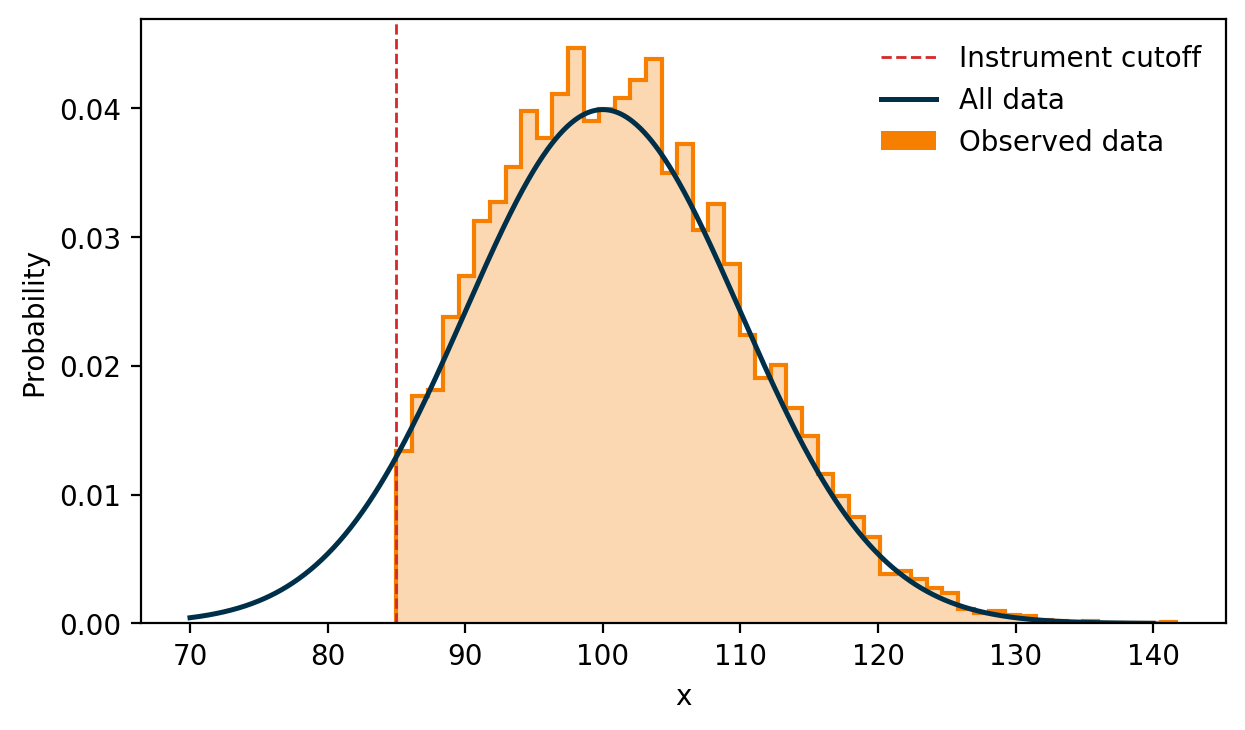

In [15]:
import matplotlib.pyplot as plt
import numpy as np
n = 10000
alpha = 85
mu, sigma = 100, 10
x = np.random.normal(mu, sigma, size=n)
mask = x > alpha
x_good = x[mask]

fig, ax = plt.subplots(figsize=(7,4))
ax.hist(x_good, label="Observed data", color='#F77F00', alpha=0.3, density=True)
ax.hist(x_good, histtype="step", color='#F77F00', linewidth=1.5, density=True)

xs = np.linspace(70, 140, 1000)
ax.axvline(alpha, ls="--", lw=1.0, label="Instrument cutoff", color='#D62828')
from scipy.stats import norm
ax.plot(xs, norm(mu, sigma).pdf(xs), label="All data", lw=1.8)
leg = ax.legend(frameon=False, loc=1)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
ax.set_xlabel("x")
ax.set_ylabel("Probability");

!!!main

So it looks like for our example data, we've got some gaussian-like distribution of $x$ observations, but at some point it seems like our instrument is unable to pick up the observations. Maybe its brightness and its too dim! Or maybe something else, who knows! But regardless, we can work with this.

To start at the beginning, let's write out the full formula for our posterior:

$$ P(\theta|d) = \frac{P(d|\theta) P(\theta)}{P(d)} $$

Everything looks good, so let's home in here on the likelihood. Now, what we should also do to make our lives easier if we write out the fact we have some sort of *selection effect* applying to our model. That is, some separate probability that dictates our experiment successfully observes an event which actually happened.

$$ P(d|\theta) \rightarrow P(d|\theta, S), $$

where $S$ in colloquial English represents "we successfully observed the event". Now, we can normally write our selection probability given data or model easily, so we want to get things into a state where we have $P(S\|d,\theta)$. Via some probability manipulation we can twist this around and get the following:

$$ P(d|\theta, S) = \frac{P(S|d,\theta) P(d|\theta)}{P(S|\theta)} $$

So let's break that down. Our likelihood given our model and our selection effects is given by the chance we observed our experimenal data (which is going to be $1$ for deterministic processes given we **have** observed it already) multiplied by our standard likelihood where we ignore selection effects, divided by the chance of observing data in general at the area in parameter space.

Now the denominator here cannot be evaluated in its current state, we need to introduce an integral over all data (denoted $D$) such that we can apply the selection effect on it.

$$ P(d|\theta, S) = \frac{P(S|d,\theta) P(d|\theta)}{\int P(S|D, \theta) P(D|\theta) dD} $$


## The Simplest Gaussian Example

Let's assume we have data samples of some observable $d$. In our model, $d$ is drawn from a normal distribution such that we wish to characterise two model parameters describing said normal - the mean $\mu$ and the standard deviation $\sigma$.

$$ P(d|\mu, \sigma) = \mathcal{N}(d|\mu, \sigma) $$

Now let's imagine the case as described in our data where we can only observe some value when its above a threshold of $\alpha$. Or more formally, 

$$P(S|d, \theta) = \mathcal{H}(d-\alpha),$$

where $\mathcal{H}$ is the Heaviside step function:

$$ \mathcal{H}(y)\equiv \begin{cases}
1 \quad {\rm if }\  y \ge 0 \\
0 \quad {\rm otherwise.}
\end{cases} $$

You can see that this selection probability is deterministic, so any data we did observe we observed with a probability of one. This helps simplify the numerator such that $P(S\|d,\theta) = 1$. Which just leaves us the denominator:

$$ \int P(S|D, \theta) P(D|\mu, \sigma) dD = \int \mathcal{H}(d-\alpha) \mathcal{N}(D|\mu, \sigma) dD $$

And because the Heaviside step function sets all $d<\alpha$ to zero, we can simply modify the bounds of the integral and do this analytically:

$$\begin{align}
\int \mathcal{H}(d-\alpha) P(D|\mu, \sigma) dD &= \int_{\alpha}^\infty \mathcal{N}(D|\mu, \sigma)\, dD \\ &= \frac{1}{2} {\rm erfc}\left[ \frac{\alpha - \mu}{\sqrt{2}\sigma} \right]
\end{align}$$

So this means we can throw this denominator back into our full expression for the likelihood:

$$ P(d|\mu, \sigma, S) = \frac{2\mathcal{N}(d|\mu, \sigma)}{ {\rm erfc}\left[ \frac{\alpha - \mu}{\sqrt{2}\sigma} \right]} $$

Finally, we should note this likelihood (and correction) is for one data point. If we had a hundred data points, we'd do this multiplicatively for each $d$.

## Verifying the selection-corrected likelihood

To do this, lets first generate a dataset, create a model, fit it with `emcee` and verify that our estimations of $\mu$ and $\sigma$ are unbiased. First, the dataset.

In [50]:
import numpy as np
np.random.seed(3)
mu, sigma, alpha, num_points = 100, 10, 85, 1000
d_all = np.random.normal(mu, sigma, size=num_points)
d = d_all[d_all > alpha]

This is the same code used to generat the plot you saw up the top, just with less datapoints! Let's create our model, one with the sample selection, and one without. Remember, we work in log space for probability, so that you don't get tripped up when reading the code implementation of the math above.

In [51]:
from scipy.stats import norm
from scipy.special import erfc

def uncorrected_likelihood(xs, data):
    mu, sigma = xs
    if sigma < 0:
        return -np.inf
    return norm(mu, sigma).logpdf(data).sum()

def corrected_likelihood(xs, data):
    mu, sigma = xs
    if sigma < 0:
        return -np.inf
    correction = data.size * np.log(0.5 * erfc((alpha - mu)/(np.sqrt(2) * sigma)))
    return uncorrected_likelihood(xs, data) - correction

Note here that I've been cheeky and included flat priors and a prior boundary to keep $\sigma$ positive in the likehood, which means I should really call it the posterior, but let's not get bogged down on semantics.

With that, our model is fully defined. We can now try and fit it to the data to see how we go.

### Model Fitting
Let's use my go-to solution, `emcee` to sample our likelihood given our dataset, and `ChainConsumer` to take those samples and turn them into handy plots. If you want more details check out the [Bayesian Linear Regression tutorial](/tutorial/2019/07/27/BayesianLinearRegression.html) for implementation details. 

C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


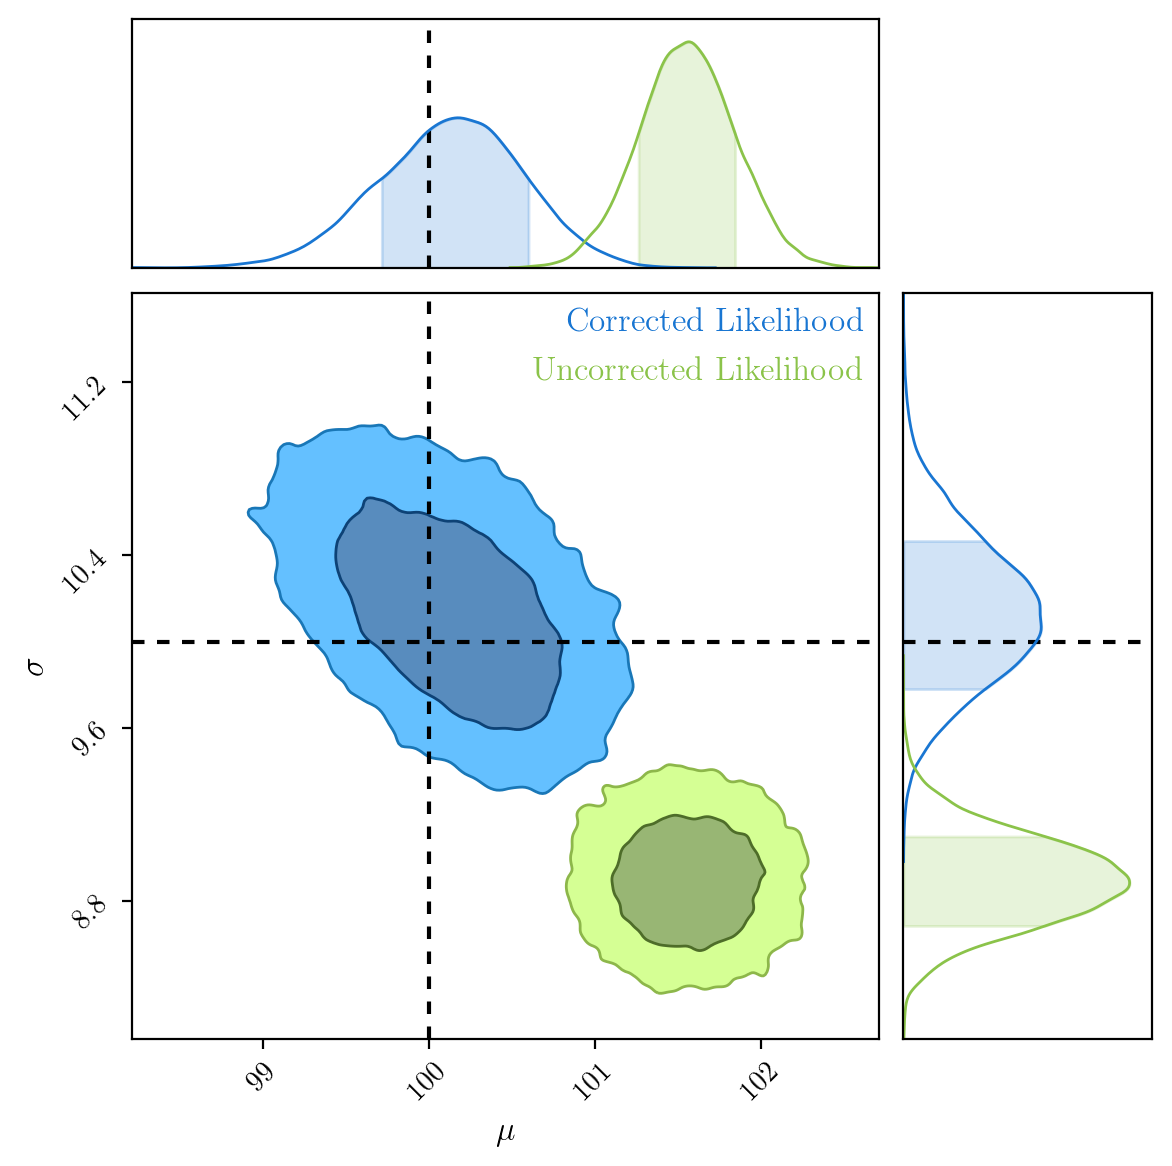

In [53]:
from chainconsumer import ChainConsumer
import emcee

ndim = 2
nwalkers = 50
p0 = np.array([95, 0]) + np.random.uniform(low=1, high=10, size=(nwalkers, ndim))
c = ChainConsumer()

functions = [corrected_likelihood, uncorrected_likelihood]
names = ["Corrected Likelihood", "Uncorrected Likelihood"]
for fn, name in zip(functions, names):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, fn, args=[d])
    state = sampler.run_mcmc(p0, 2000)
    chain = sampler.chain[:, 300:, :]
    flat_chain = chain.reshape((-1, ndim))
    c.add_chain(flat_chain, parameters=["$\mu$", "$\sigma$"], name=name)

c.plotter.plot(truth=[mu, sigma], figsize=2.0);

Hopefully you can now see how the correction we applied to the likelihood unbiases its estimations.

You'll notice that the contours don't sit perfectly on the true value, but if we made a hundred realisations of the data and averaged out the contour positions, you'd see they would. [In fact, you can see it right here](https://arxiv.org/abs/1706.03856).

Thinking about the problem in this way allows us to neatly separate out the selection effects and generic likelihood so we can treat them independently. Of course, when you get past the point where analytic approximations to your selection effects aren't good enough, you can expect a good numerical hit where you have to numerically compute the correction.

But one thing that is *correct* about this approach that a lot of other approaches miss (such as adding bias corrections to your data) is that the *correction* is dependent on where you are in parameter space. And this should make sense conceptually - the correction is just answering the question "How efficient are we *in general* given our current model parametrisation". If we've charactered our instrument cannot detect $d < 85$, we expect to lose more events if the population mean is close to $85$ and less events if the population mean is at $200$.
